In [1]:
import yfinance as yf
import datetime
import numpy as np
from tensorflow import keras
import pandas as pd


#need to create a time period for 2000's - yesterday for out training data
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)

#prompt user for ticker
ticker = input("Enter your ticker: ")
Tickerdata = yf.download(ticker, start = '2005-01-01', end = yesterday) 

#Validates that a ticker has populated the DF
while len(Tickerdata) == 0:
    ticker = input("Invalid Ticker, Please Enter a Valid Ticker: ")
    ticker = ticker.upper()
    Tickerdata = yf.download(ticker, start = '2005-01-01', end = yesterday) 

#prompt for monthly contribution and validates entry is integer
contrib = input("Enter your monthly contribution amount")
while contrib.isdigit() == False:
    contrib = input("Please enter a valid integer for monthly contribution amount")
contrib = int(contrib)

#add daily earnings and next day close feature that can be used as features/targets
Tickerdata["daily_earnings"] = Tickerdata["Close"] - Tickerdata["Open"]
Tickerdata['next_day_close'] = Tickerdata["Close"].shift(-1) # includes the next rows close price, may create an NA due to close price of "today" not being updated
Tickerdata['IDE'] = Tickerdata['next_day_close'] - Tickerdata['Close'][ticker] #intraday earnings


#Add features based on the Date
Tickerdata['Weekday'] = Tickerdata.index.day_of_week
Tickerdata['Month'] = Tickerdata.index.month
Tickerdata['Year'] = Tickerdata.index.year

Tickerdata['Days_Since_Start'] = (Tickerdata.index - Tickerdata.index[0]).days #days since start tracking
Tickerdata['Years_Since_Start'] = Tickerdata['Days_Since_Start']/365
Tickerdata['Log_Close'] = np.log(Tickerdata['Close'])

#Add features based on performance

Tickerdata['SMA_30'] = Tickerdata['Close'].rolling(window = 30).mean()
Tickerdata['SMA_200'] = Tickerdata['Close'].rolling(window = 200).mean() #200 day moving average using the rolling function, will create NANS that we will drop
Tickerdata['SMA_500'] = Tickerdata['Close'].rolling(window = 500).mean()

Tickerdata.dropna(inplace=True)



2025-06-14 14:42:00.896170: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 14:42:01.062556: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-14 14:42:01.208320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749904921.326616    3788 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749904921.360233    3788 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-14 14:42:01.668907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### TRY PREDICTING DAILY RETURNS

### BEGIN PREDICTING LOG RETURS

In [2]:
#Simple Linear Regression Model That will establish a stable long term trend
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linx = Tickerdata[['Years_Since_Start']]
liny = Tickerdata['Log_Close']

linx_train,linx_test, liny_train,liny_test = train_test_split(linx, liny, test_size= .2, shuffle=False) #do not shuffle for time series data
linreg_model = LinearRegression().fit(linx_train, liny_train)
log_test = linreg_model.predict(linx_test)
price_pred = np.exp(log_test)

In [3]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
print("lin model R2: ", r2_score(np.exp(liny_test), price_pred ))

rmse = root_mean_squared_error(np.exp(liny_test), price_pred)
print("RMSE:", rmse)
mape = mean_absolute_percentage_error(np.exp(liny_test), price_pred)
print("MAPE: ",mape*100,"%")



year = Tickerdata['Years_Since_Start'].iloc[-1]

Decade = np.array([[year+10]])

future_log = linreg_model.predict(Decade)

future_price = np.exp(future_log)[0]

print('Future Price Predicted: ',future_price)

current_price = Tickerdata['Close'].iloc[-1][0]

CAGR = (future_price/current_price)**(1/10)  - 1

print('Compound Annual Growth Rate: ', CAGR)

lin model R2:  0.325872816058537
RMSE: 25.733788277159295
MAPE:  10.93534524494102 %
Future Price Predicted:  2922.0229539052043
Compound Annual Growth Rate:  0.30837155590330445


In [4]:
Tickerdata

Price,Close,High,Low,Open,Volume,daily_earnings,next_day_close,IDE,Weekday,Month,Year,Days_Since_Start,Years_Since_Start,Log_Close,SMA_30,SMA_200,SMA_500
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2006-12-26,2.449716,2.481574,2.431083,2.468951,490688800,-0.019235,2.450018,0.000302,1,12,2006,722,1.978082,0.895972,2.633628,2.111682,1.760490
2006-12-27,2.450018,2.464443,2.307260,2.348734,1935754800,0.101283,2.430482,-0.019535,2,12,2006,723,1.980822,0.896095,2.630793,2.113816,1.763488
2006-12-28,2.430482,2.441903,2.393817,2.410947,1119876800,0.019535,2.549797,0.119315,3,12,2006,724,1.983562,0.888090,2.626656,2.116016,1.766427
2006-12-29,2.549797,2.566628,2.505317,2.523049,1076429200,0.026748,2.518541,-0.031257,4,12,2006,725,1.986301,0.936014,2.627447,2.119101,1.769588
2007-01-03,2.518541,2.602092,2.461438,2.593376,1238319600,-0.074835,2.574442,0.055902,2,1,2007,730,2.000000,0.923680,2.625634,2.121977,1.772685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,200.630005,204.750000,200.149994,203.500000,55126100,-2.869995,203.919998,3.289993,3,6,2025,7458,20.432877,5.301462,204.652951,224.732911,202.192152
2025-06-06,203.919998,205.699997,202.050003,203.000000,46607700,0.919998,201.449997,-2.470001,4,6,2025,7459,20.435616,5.317728,204.513714,224.627017,202.242432


In [5]:


short_term_features = ['Weekday', 'Month', 'Open','Years_Since_Start','Days_Since_Start', 'SMA_200', 'SMA_500']
x = Tickerdata[short_term_features]
y = Tickerdata['Log_Close'].values.reshape(-1, 1) 

from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
xscale= xscaler.fit_transform(x)
yscale = yscaler.fit_transform(y)

In [6]:
window = int(len(Tickerdata)/2)


def train_lstm(x, y, window):
    x_lstm, y_lstm = [], []
    for i in range(window, len(x)):
        x_lstm.append(x[i-window:i])
        y_lstm.append(y[i]) 
        # creates 30 day chunks one day at a time, overlapping one day at a time until the last day of the dataframe for x to predict the end 30 day chunk of y
    return np.array(x_lstm), np.array(y_lstm)
x_lstm, y_lstm = train_lstm(xscale, yscale, window)

x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.2, shuffle=False)


In [7]:

model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))) 
model.add(keras.layers.LSTM(128, return_sequences=True )) 
model.add(keras.layers.LSTM(128, return_sequences=False )) 

#model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
model.summary()

2025-06-14 14:42:08.376677: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/eduard/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2322, 128)      │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 2322, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,929 (1.27 MB)

 Trainable params: 332,929 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
hist = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=.3, verbose=1,callbacks =
                
    [tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mean_absolute_percentage_error', mode = 'min',
    patience = 10,
    restore_best_weights = True
    )])

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0758 - mean_absolute_percentage_error: 48.0952 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 3.7445
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 0.0052 - mean_absolute_percentage_error: 23.8812 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 4.8056
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 0.0028 - mean_absolute_percentage_error: 17.4868 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 3.3983
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - loss: 0.0020 - mean_absolute_percentage_error: 15.5736 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 8.7524
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - loss: 0.0020 - mean_absolute_percentage_error: 16.1718 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 6.7834


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 732ms/step


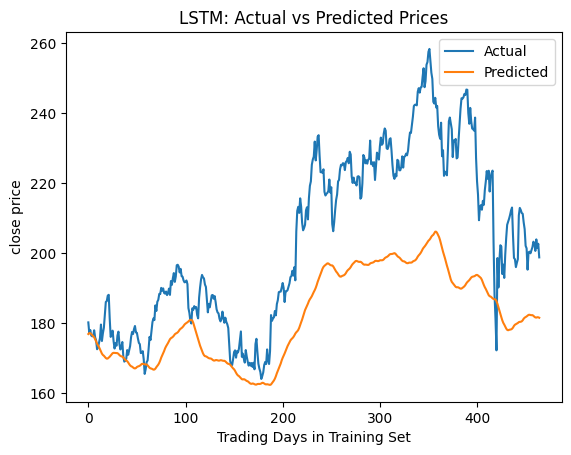

RMSE: 25.733788277159295
R2:  -0.04810941004045022
MAPE: 9.910474918249076 %


In [9]:
y_pred = model.predict(x_test)
y_pred_real = yscaler.inverse_transform(y_pred)
y_test_real = yscaler.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt
plt.plot(np.exp(y_test_real), label='Actual')
plt.plot(np.exp(y_pred_real), label='Predicted')
plt.title("LSTM: Actual vs Predicted Prices")
plt.legend()
plt.xlabel('Trading Days in Training Set')
plt.ylabel('close price')
plt.show()

LSTM_rmse = root_mean_squared_error(np.exp(y_test_real),np.exp(y_pred_real))
LSTM_r2 = r2_score(np.exp(y_test_real),np.exp(y_pred_real))
LSTM_mape = mean_absolute_percentage_error(np.exp(y_test_real),np.exp(y_pred_real))

print(f"RMSE:" ,rmse)   

print(f"R2: ", LSTM_r2)
print('MAPE:', LSTM_mape*100,"%")

In [15]:
Tickerdata['Close'].iloc[-1]

Ticker
AAPL    198.779999
Name: 2025-06-11 00:00:00, dtype: float64

In [10]:
from datetime import timedelta
import numpy as np


avg_IDE = Tickerdata['IDE'].iloc[-500:].mean() #average intra-day earnings from past 500 day, will add this daily as a trend

pricehist = Tickerdata['Open'].iloc[:,0]
pricehist = pricehist.iloc[-500:]
pricehist = pd.Series(pricehist)
pricehist = list(pricehist)




forecast_features = [
    'Weekday', 'Month', 'Open', "Years_Since_Start","Days_Since_Start", "SMA_200", "SMA_500"
    ]

# Setup
window = 252
forecast_days = 2520

#use some of our old data
feature_hist = xscale[-window:] 

last_day_count = Tickerdata['Days_Since_Start'].iloc[-1]
total_years = Tickerdata['Years_Since_Start'].iloc[-1]
date = Tickerdata.index[-1]
SMA_200 = Tickerdata['SMA_200'].iloc[-1]
SMA_500 = Tickerdata['SMA_500'].iloc[-1]

future_dates = []
pred_log = []
pred_price = []


#create a daily trend variable to add a trend to the data 
daily_trend=avg_IDE



for i in range(forecast_days):
    date += timedelta(days=1)
    while date.weekday() > 4:
        date += timedelta(days=1) 
    # Reshape our data for LSTM
    LSTM_input = feature_hist.reshape(1, window, -1)
    #Predict on our datapricehist = Tickerdata['Open'].iloc[-500:]
    log_scaled = model.predict(LSTM_input)[0, 0]
    #transform our target
    log_real = yscaler.inverse_transform([[log_scaled]])[0, 0]
    
    #add hlmean to our log_real to create upwards drift
    log_real_trend = log_real + daily_trend
    #append our predicted log value to list
    pred_log.append(log_real)


    #exponentiate to list of predictions in dollars
    price = float(np.exp(log_real_trend))#cast to float to avoid error
    pred_price.append(price)
    pricehist.append(price)
    pricehist = pricehist[-500:]
    #skip non trading days
    SMA_200 = np.mean(pricehist[-200:])
    SMA_500=  np.mean(pricehist[-500:])
    
    #append next trading day to 
    future_dates.append(date)
    # 3. Generate next row using predicted price as "Open"
    year = total_years + (i+1) / 252
    new_row = {
        'Weekday':date.weekday(),
        'Month': date.month,
        'Open': price,
        'Year': date.year,
        'Years_Since_Start': year,
        'Days_Since_Start': last_day_count + i + 1,   
        'SMA_200':SMA_200,
        'SMA_500':SMA_500
    }
    #create array of features
    new_vals = np.array([[new_row[feat] for feat in forecast_features]])
    #scale the new vals
    new_scaled = xscaler.transform(new_vals)

    #  Update window
    feature_hist = np.vstack([feature_hist, new_scaled])[-window:]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

In [11]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Log_Close_Pred': pred_log,
    'Close_Pred': pred_price
}).set_index('Date')
LSTM_final = forecast_df['Close_Pred'].iloc[-1]
LSTM_final

213.94534338037246

### fix the initiial value problem

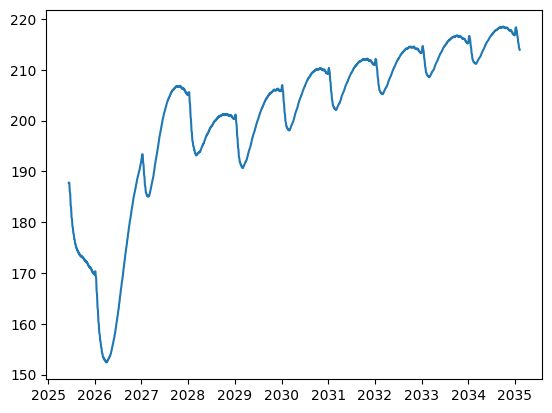

In [12]:

forecast_df


#pricehist = Tickerdata['Open'].iloc[-500:]

#pricehist

plt.plot(forecast_df['Close_Pred'])
plt.show()

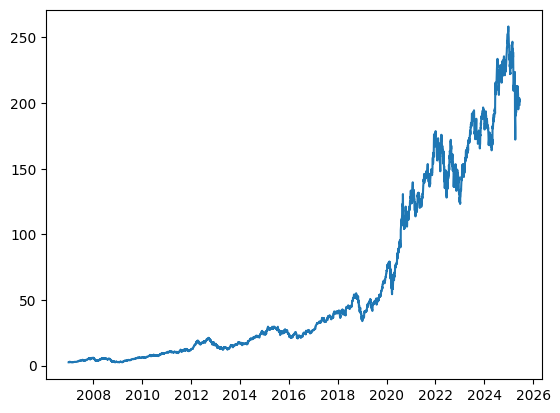

In [13]:
plt.plot(Tickerdata['Close'])
plt.show()

In [16]:
forecast_df['Close_Pred'].iloc[0]

187.76924251945445